In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgb_hp_tuner import XGBoostHyperparameterTuner
import matplotlib.pyplot as plt

/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/two_class_pp_5s_0.5.csv"
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)

In [3]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

In [4]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [5]:
select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
81,gyr_y_hjorth_frequency,139.842482
11,acc_x_spectral_flatness,135.375100
78,gyr_y_spectral_spread,135.147833
95,gyr_z_spectral_spread,125.213107
98,gyr_z_hjorth_frequency,122.914314
...,...,...
23,acc_y_min,4.194527
70,gyr_y_mean,3.864838
40,acc_z_min,1.630851
53,gyr_x_mean,0.029069


In [6]:
model = XGBClassifier(
    n_estimators=284,
    max_depth=9,
    learning_rate=0.03730930,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=3.6165,
    reg_alpha=1.5085,
    reg_lambda=1.29783,
)

In [7]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

3 fold hyperparameter tuning

In [8]:
# tuner = XGBoostHyperparameterTuner(
#         X_train=X_train_selected, 
#         y_train=y_train, 
#         groups_train=groups_train,
#         positive_class='void',
#         folds=3,
#         n_trials=50,
#         random_state=42
#     )

In [9]:
# Optimize hyperparameters
# best_params, best_score = tuner.optimize_hyperparameters(verbose=True)

In [10]:
# model = tuner.get_best_model()

In [11]:
# model.fit(X_train, y_train)
model.fit(X_train_selected, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
classes = ['non-void', 'void']

In [13]:
classes = ['non-void', 'void']
# y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
report = classification_report(y_test, y_pred, labels=[0, 1], target_names=classes)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       149
           1       0.80      0.39      0.53        94

    accuracy                           0.73       243
   macro avg       0.76      0.67      0.67       243
weighted avg       0.75      0.73      0.70       243



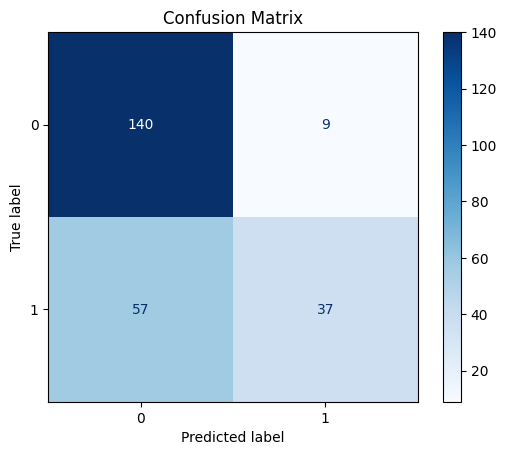

In [14]:
labels_ordered = ['void', 'non-void']
# Confusion matrix with void on top
cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()

In [15]:
select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
81,gyr_y_hjorth_frequency,139.842482
11,acc_x_spectral_flatness,135.375100
78,gyr_y_spectral_spread,135.147833
95,gyr_z_spectral_spread,125.213107
98,gyr_z_hjorth_frequency,122.914314
...,...,...
23,acc_y_min,4.194527
70,gyr_y_mean,3.864838
40,acc_z_min,1.630851
53,gyr_x_mean,0.029069


In [16]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [17]:
model = RandomForestClassifier(
        n_estimators=311,
        max_depth=7,
        min_samples_split=14,
        min_samples_leaf=9,
        max_features='sqrt',
        bootstrap=False,
        class_weight='balanced',
        random_state=42)

In [18]:
model.fit(X_train, y_train)
model.fit(X_train_selected, y_train)

,n_estimators,311
,criterion,'gini'
,max_depth,7
,min_samples_split,14
,min_samples_leaf,9
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [19]:
classes = ['non-void', 'void']
# y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
report = classification_report(y_test, y_pred, labels=[0, 1], target_names=classes)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       149
           1       0.80      0.43      0.56        94

    accuracy                           0.74       243
   macro avg       0.76      0.68      0.68       243
weighted avg       0.75      0.74      0.71       243



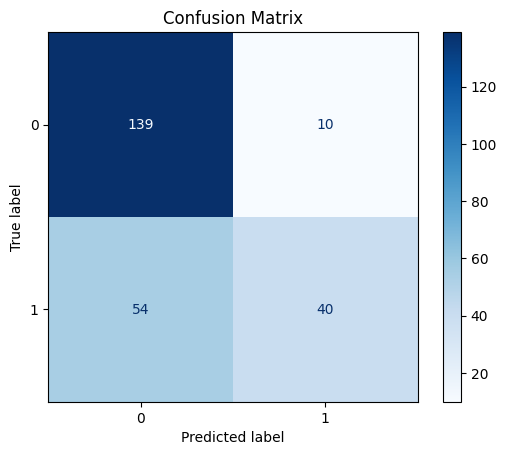

In [20]:
labels_ordered = ['void', 'non-void']
# Confusion matrix with void on top
cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()

Getting back

In [22]:
# Keep everything together for easier analysis
test_results = pd.DataFrame({
    'group': groups_test,
    'actual': y_test,
    'predicted': y_pred
})
data = {}

# Now you can easily analyze by group
for group_id in test_results['group'].unique():
    group_data = test_results[test_results['group'] == group_id]
    data[group_id] = group_data
    print(f"Group {group_id}: {len(group_data)} samples")
    print(f"Predictions: {group_data['predicted'].tolist()}")

Group 5: 13 samples
Predictions: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Group 9: 30 samples
Predictions: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Group 14: 24 samples
Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Group 20: 12 samples
Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Group 25: 31 samples
Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 26: 25 samples
Predictions: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 30: 18 samples
Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Group 40: 75 samples
Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 41: 15 samples
Predictions: [0, 

In [28]:
predicted_labels = data[5]['predicted'].tolist()
predicted_labels

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

In [29]:
# Method 2: If windows are consecutive with known step size
def reconstruct_with_step(predictions, window_size, step_size, start_time=0):
    """
    Reconstruct when you know the step size between windows
    """
    timeline_positions = []
    timeline_predictions = []
    
    for i, pred in enumerate(predictions):
        # Calculate the center time of this window
        window_start = start_time + (i * step_size)
        window_center = window_start + (window_size // 2)
        
        timeline_positions.append(window_center)
        timeline_predictions.append(pred)
    
    return pd.DataFrame({
        'time_position': timeline_positions,
        'prediction': timeline_predictions
    })

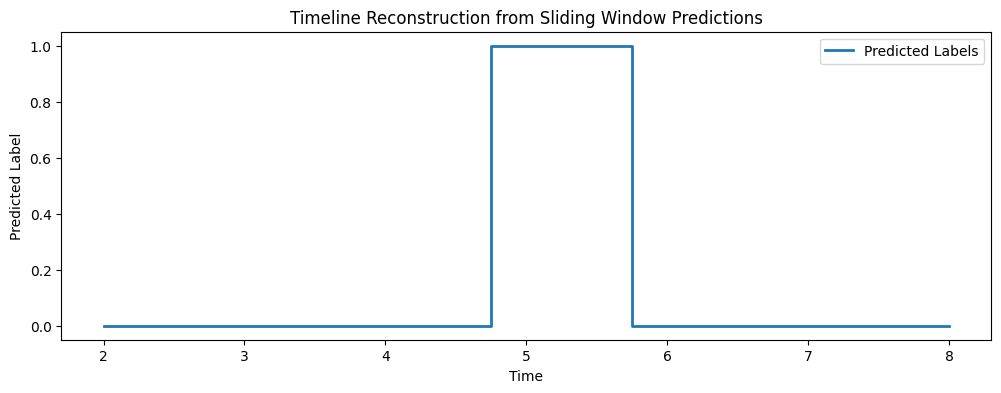

In [ ]:
import matplotlib.pyplot as plt

# Reconstruct your timeline
timeline_df = reconstruct_with_step(predicted_labels, window_size=5, step_size=0.5)

# Plot like your diagram
plt.figure(figsize=(12, 4))

# Plot the predictions as a timeline
plt.step(timeline_df['time_position'], timeline_df['prediction'], 
         where='mid', linewidth=2, label='Predicted Labels')

# Add ground truth regions if you have them
# plt.axvspan(pre_void_start, pre_void_end, alpha=0.3, color='red', label='Non-void')
# plt.axvspan(void_start, void_end, alpha=0.3, color='blue', label='Void')
# plt.axvspan(post_void_start, post_void_end, alpha=0.3, color='green', label='Non-void')

plt.xlabel('Time')
plt.ylabel('Predicted Label')
plt.title('Timeline Reconstruction from Sliding Window Predictions')
plt.legend()
plt.show()